# Data Mining Project 2

https://datacatalog.cookcountyil.gov/Property-Taxation/Assessor-Archived-05-11-2022-Residential-Sales-Dat/5pge-nu6u/about_data

1. Data Acquisition

In [6]:
import requests
import pandas as pd
import numpy as np

In [7]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [8]:
# or mini2/cook_county_train_val.csv
df = pd.read_csv("cook_county_train_val.csv")

In [9]:
print(len(df))

204792


In [10]:
print(df.head())

   Unnamed: 0             PIN  Property Class  Neighborhood Code  \
0           0  17294100610000             203                 50   
1           1  13272240180000             202                120   
2           2  25221150230000             202                210   
3           3  10251130030000             203                220   
4           4  31361040550000             202                120   

   Land Square Feet  Town Code  Apartments  Wall Material  Roof Material  \
0            2500.0         76         0.0            2.0            1.0   
1            3780.0         71         0.0            2.0            1.0   
2            4375.0         70         0.0            2.0            1.0   
3            4375.0         17         0.0            3.0            1.0   
4            8400.0         32         0.0            3.0            1.0   

   Basement  Basement Finish  Central Heating  Other Heating  Central Air  \
0       1.0              3.0              1.0            

2. Data Cleaning

In [11]:
# no missing values
count = df.count()
print(count)

Unnamed: 0                    204792
PIN                           204792
Property Class                204792
Neighborhood Code             204792
Land Square Feet              204792
Town Code                     204792
Apartments                    204792
Wall Material                 204792
Roof Material                 204792
Basement                      204792
Basement Finish               204792
Central Heating               204792
Other Heating                 204792
Central Air                   204792
Fireplaces                    204792
Attic Type                    204792
Attic Finish                  204792
Design Plan                   204792
Cathedral Ceiling             204792
Construction Quality          204792
Site Desirability             204792
Garage 1 Size                 204792
Garage 1 Material             204792
Garage 1 Attachment           204792
Garage 1 Area                 204792
Garage 2 Size                 204792
Garage 2 Material             204792
G

In [12]:
# clean out sale prices equal to 1 or 0
print(len(df[df['Sale Price'] < 2]))
df = df[df['Sale Price'] > 1]

35546


In [ ]:
# drop non numeric columns
# could drop Property Class, Town Code, Neighborhood code, Census Tract, Town and Neighborhood
df = df.drop(columns=['PIN', 'Deed No.', 'Modeling Group', 'Description'])

In [ ]:
# drop empty / mostly empty columns
# could drop "Multi Property Indicator" as well
df = df.drop(columns=['Apartments', 'Garage 2 Material', 'Garage 2 Attachment', 'Garage 2 Area', 'Number of Commercial Units', 'Use'])

In [ ]:
# regex out description details or remove them
df = df.drop(columns=['Description'])

In [15]:
# remove outliers with Isolation Forest
from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination=0.05)
yhat = iso.fit_predict(df[['Sale Price']])
mask = yhat != -1
df = df[mask]

3. Data Visualization

In [16]:
import matplotlib.pyplot as plt

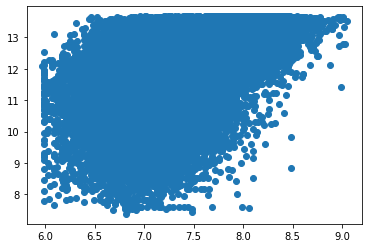

In [17]:
# scatter plot of building square feet vs sale price
plt.scatter(np.log(df['Building Square Feet']), np.log(df['Sale Price']))


4. Hypothesis Development

5. Model Development

In [3]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, LinearRegression
from scipy.interpolate import CubicSpline

In [4]:
# 5-fold Cross Validation
def cross_validate(model, X, y, n_folds=5):
    scores = cross_val_score(model, X, y, cv=n_folds, scoring='neg_mean_squared_error')
    return int(np.sqrt((-np.mean(scores))))

In [18]:
# Simple Regression
def simple_regression(X, y):
    model = LinearRegression()
    model.fit(X, y)
    return model

model = simple_regression(df[['Estimate (Land)']], df['Sale Price'])

print("Simple Regression Error: ")
print(cross_validate(model, df[['Estimate (Land)']], df['Sale Price']))

Simple Regression Error: 
149693


In [20]:
# Multiple Regression with all features
def multiple_regression(X, y):
    model = LinearRegression()
    model.fit(X, y)
    return model


multiple_model = multiple_regression(df.drop(columns=['Sale Price']), df['Sale Price'])

print("Multiple Regression Error: ")
print(cross_validate(multiple_model, df.drop(columns=['Sale Price']), df['Sale Price']))


ValueError: could not convert string to float: 'SF'

In [21]:
# Subset Selection
def subset_selection(X, y, k):
    selector = SelectKBest(score_func=f_regression, k=k)
    return selector.fit_transform(X, y)


# Multiple Regression with subset of features
k = 15
X = subset_selection(df.drop(columns=['Sale Price']), df['Sale Price'], k)
subset_model = multiple_regression(X, df['Sale Price'])

print("Subset Regression Error: ")
print(cross_validate(subset_model, X, df['Sale Price']))

ValueError: could not convert string to float: 'SF'

In [22]:
# Regularization
def pca(X, y, k):
    model = PCA(n_components=k)
    model = model.fit_transform(X, y)

    return model

k = 15
X = pca(df.drop(columns=['Sale Price']), df['Sale Price'], k)
pca_model = multiple_regression(X, df['Sale Price'])

print("PCA Regression Error: ")
print(cross_validate(pca_model, X, df['Sale Price']))

ValueError: could not convert string to float: 'SF'

In [23]:
# Polynomial regression
def polynomial_regression(X, y, degree):
    print("Fitting polynomial regression model with degree:", degree)
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)
    model = LinearRegression()
    model.fit(X_poly, y)
    return model


X = df.drop(columns=['Sale Price'])
y = df['Sale Price']
degree = 1  # Might need tuning
poly_model = polynomial_regression(X, y, degree)

print("Polynomial Regression Error: ")
print(cross_validate(poly_model, X, y))

Fitting polynomial regression model with degree: 1


ValueError: could not convert string to float: 'SF'

In [24]:
# Scipy cubic spline interpolation
class CubicSplineRegressor:
    def __init__(self):
        self.models = []

    def fit(self, X, y):
        self.models = []
        for column in X.columns:
            X_sorted, y_sorted = zip(*sorted(zip(X[column], y)))
            X_sorted, y_sorted = np.unique(X_sorted, return_index=True)
            y_sorted = np.array(y)[y_sorted]

            model = CubicSpline(X_sorted, y_sorted, bc_type='natural')  
            self.models.append(model)
        return self

    def predict(self, X):
        y_pred = np.zeros(len(X))
        for i, column in enumerate(X.columns):
            spline_model = self.models[i]
            y_pred += spline_model(X[column])
        return y_pred
    
    
    def get_params(self, deep=True):
        return {}

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self
    

X = df.drop(columns=['Sale Price'])
y = df['Sale Price']
spline_model = CubicSplineRegressor()

print("Spline Regression Error: ")
print(cross_validate(spline_model, X, y))

Spline Regression Error: 


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\riley\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "<ipython-input-24-0519314a136c>", line 13, in fit
    model = CubicSpline(X_sorted, y_sorted, bc_type='natural')
  File "c:\Users\riley\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\interpolate\_cubic.py", line 629, in __init__
    x, dx, y, axis, _ = prepare_input(x, y, axis)
  File "c:\Users\riley\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\interpolate\_cubic.py", line 26, in prepare_input
    x = x.astype(float)
ValueError: could not convert string to float: 'SF'


In [ ]:
# Lasso Regularization
def lassocv_regularization(X, y):
    lasso_cv = LassoCV(cv=5).fit(X, y)
    return lasso_cv

X = df.drop(columns=['Sale Price'])
y = df['Sale Price']

lasscv_model = lassocv_regularization(X, y)

print("Lasso Regression Error: ")
print(lasscv_model.score(X, y)) # this uses the R^2 score

In [ ]:
# Ridge Regularization
def ridgecv_regularization(X, y):
    ridgecv_model = RidgeCV(cv=5).fit(X, y)
    return ridgecv_model

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop(columns=['Sale Price']))
y = df['Sale Price']

ridgecv_model = ridgecv_regularization(X_scaled, y)

print("Ridge Regression Error: ")
print(ridgecv_model.score(X_scaled, y)) # this is the R^2 score